In [22]:
import os
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm.notebook as tqdm

import nygrid.gen_params as gp

In [23]:
# Set up directories
cwd = os.getcwd()
if 'examples' in cwd:
    parent_dir = os.path.dirname(cwd)
    data_dir = os.path.join(parent_dir, 'data')
else:
    data_dir = os.path.join(cwd, 'data')

grid_data_dir = os.path.join(data_dir, 'grid', '2018NewParams')
if not os.path.exists(grid_data_dir):
    raise FileNotFoundError('Grid data directory not found.')

thermal_data_dir = os.path.join(data_dir, 'thermal')
if not os.path.exists(thermal_data_dir):
    raise FileNotFoundError('Thermal data directory not found.')

print('Grid data directory: {}'.format(grid_data_dir))
print('Thermal data directory: {}'.format(thermal_data_dir))

fig_dir = os.path.join(os.path.dirname(data_dir), 'figures')
print('Figure directory: {}'.format(fig_dir))

results_dir = os.path.join(os.path.dirname(data_dir), 'results')
print('Results directory: {}'.format(results_dir))


Grid data directory: /mnt/Bo_HDD/NYgrid-python/data/grid/2018NewParams
Thermal data directory: /mnt/Bo_HDD/NYgrid-python/data/thermal
Figure directory: /mnt/Bo_HDD/NYgrid-python/figures
Results directory: /mnt/Bo_HDD/NYgrid-python/results


# 1. Read NYCA and CEMS generator matching table

In [24]:
gen_combiner = pd.read_excel(os.path.join(thermal_data_dir, '2018_nyca_thermal.xlsx'),
                             sheet_name='matched_with_id_filtered')
gen_combiner = gen_combiner.rename(columns={
    '   Station        Unit': 'NYISO_Name',
})

# Map unit type GT, JE to CT
gen_combiner['Unit Type'] = gen_combiner['Unit Type'].replace(
    {'GT': 'CT', 'JE': 'CT'})
gen_combiner['Fuel Type Secondary'] = gen_combiner['Fuel Type Secondary'].astype(
    str).replace({'nan': ''})

gen_combiner['GEN_NAME'] = gen_combiner['NYISO_Name'] + gen_combiner['ID']
gen_combiner

,NYISO_Name,Zone,PTID,Name Plate Rating (MW),Dual Fuel,Unit Type,Fuel Type Primary,Fuel Type Secondary,2017 Net Energy (GWh),Note,...,CAMD_Unit_ID,CAMD_Generator_ID,CAMD_Nameplate_Capacity,CAMD_Fuel_Type,EIA_Latitude,EIA_Longitude,ID,eco_min_ratio_obs,gen_bus,GEN_NAME
0,Danskammer 1,G,23586,72.0,YES,ST,NG,FO6,0.93040,NaN,...,1,1,72.0,Pipeline Natural Gas,41.571247,-73.974981,"(2480,1)",0.50,77,"Danskammer 1(2480,1)"
1,Danskammer 2,G,23589,73.5,YES,ST,NG,FO6,0.90830,NaN,...,2,2,73.5,Pipeline Natural Gas,41.571247,-73.974981,"(2480,2)",0.50,77,"Danskammer 2(2480,2)"
2,Danskammer 3,G,23590,147.1,NaN,ST,NG,,2.06448,NaN,...,3,3,147.1,Pipeline Natural Gas,41.571247,-73.974981,"(2480,3)",0.50,77,"Danskammer 3(2480,3)"
3,Danskammer 4,G,23591,239.4,NaN,ST,NG,,5.05390,NaN,...,4,4,239.4,Pipeline Natural Gas,41.571247,-73.974981,"(2480,4)",0.50,77,"Danskammer 4(2480,4)"
4,Arthur Kill ST 2,J,23512,376.2,NaN,ST,NG,,563.62800,NaN,...,20,2,376.2,Pipeline Natural Gas,40.591564,-74.200035,"(2490,20)",0.28,82,"Arthur Kill ST 2(2490,20)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
231,Bayonne EC CTG4,J,323685,64.0,YES,CT,NG,KER,67.92100,NJ,...,GT4,GT4,64.0,Pipeline Natural Gas,40.652834,-74.091550,"(56964,GT4)",0.80,81,"Bayonne EC CTG4(56964,GT4)"
232,Bayonne EC CTG5,J,323686,64.0,YES,CT,NG,KER,89.64800,NJ,...,GT5,GT5,64.0,Pipeline Natural Gas,40.652834,-74.091550,"(56964,GT5)",0.80,81,"Bayonne EC CTG5(56964,GT5)"
233,Bayonne EC CTG6,J,323687,64.0,YES,CT,NG,KER,72.82700,NJ,...,GT6,GT6,64.0,Pipeline Natural Gas,40.652834,-74.091550,"(56964,GT6)",0.80,81,"Bayonne EC CTG6(56964,GT6)"
234,Bayonne EC CTG7,J,323688,64.0,YES,CT,NG,KER,83.81700,NJ,...,GT7,GT7,64.0,Pipeline Natural Gas,40.652834,-74.091550,"(56964,GT7)",0.80,81,"Bayonne EC CTG7(56964,GT7)"


In [25]:
# Remove NJ generators
# Bayonne Energy Center_56964 # Unit 9 and 10 are not in 2018
# Linden Cogeneration Facility_50006
gen_combiner = gen_combiner[~gen_combiner['CAMD_Plant_ID'].isin([56964, 50006])]

# 2. Read 2018 CESM data

In [26]:
cems_data_dir = os.path.join(thermal_data_dir, 'cems_2018')
df_list = list()
for mo in range(1, 13):
    df = pd.read_csv(os.path.join(cems_data_dir, f'2018ny{str(mo).zfill(2)}.csv'),
                     low_memory=False)
    df_list.append(df)

# Concatenate all the dataframes
cems_df = pd.concat(df_list, axis=0, ignore_index=True)

# Rename columns
cems_df = cems_df.rename(columns={
    'ORISPL_CODE': 'Plant_ID',
    'UNITID': 'Unit_ID',
})

# Add time columns from OP_DATE and OP_HOUR
cems_df['Time'] = pd.to_datetime(
    cems_df['OP_DATE']) + pd.to_timedelta(cems_df['OP_HOUR'], unit='h')
# cems_df['Month'] = cems_df['Time'].dt.month

# Drop columns that are not needed
cems_df = cems_df.drop(columns=['STATE', 'FAC_ID', 'UNIT_ID', 'OP_DATE', 'OP_HOUR',
                                'SO2_MASS_MEASURE_FLG', 'SO2_RATE_MEASURE_FLG',
                                'NOX_MASS_MEASURE_FLG', 'NOX_RATE_MEASURE_FLG',
                                'CO2_MASS_MEASURE_FLG', 'CO2_RATE_MEASURE_FLG',
                                'SLOAD (1000lb/hr)'])

In [27]:
cems_gload = dict()
cems_heat_input = dict()

for ii in range(gen_combiner.shape[0]):

    gen_info = gen_combiner.iloc[ii]

    unit_df = cems_df[(cems_df['Plant_ID'] == gen_info['CAMD_Plant_ID'])
                        & (cems_df['Unit_ID'] == gen_info['CAMD_Unit_ID'])]
    unit_df = unit_df.set_index('Time').sort_index()
    
    cems_gload[gen_info['GEN_NAME']] = unit_df['GLOAD (MW)']
    cems_heat_input[gen_info['GEN_NAME']] = unit_df['HEAT_INPUT (mmBtu)']

# Create a dataframe from the dictionary
cems_gload_df = pd.DataFrame(cems_gload)
cems_heat_input_df = pd.DataFrame(cems_heat_input)

# 3. Read NYGrid generator dispatch

In [28]:
# Cost modifiers
ext_cost_factor = 0.0
fo_cost_factor = 1.0

In [29]:
sim_name = f'2018NewParams_ext{ext_cost_factor}_fo{fo_cost_factor}_daily'

nygrid_glaod_df = pd.read_csv(os.path.join(results_dir, sim_name,
                                           f'thermal_pg_{sim_name}.csv'),
                                           index_col=0, parse_dates=True)
nygrid_heat_input_df = pd.read_csv(os.path.join(results_dir, sim_name,
                                                f'heat_input_{sim_name}.csv'),
                                                index_col=0, parse_dates=True)

# 4. Aggregate by unit type and fuel type

In [30]:
gen_fuel = gen_combiner[['GEN_NAME','Unit Type', 'Fuel Type Primary']].copy()
gen_fuel['GEN_FUEL'] = gen_fuel['Unit Type'] + '_' + gen_fuel['Fuel Type Primary']
gen_fuel_dict = gen_fuel.set_index('GEN_NAME')['GEN_FUEL'].to_dict()

# GlOAD grouped by unit type and fuel type
cems_gload_summary = cems_gload_df.groupby(gen_fuel_dict, axis=1).sum()
nygrid_gload_summary = nygrid_glaod_df.groupby(gen_fuel_dict, axis=1).sum()
gen_fuel['GEN_FUEL'].unique()

array(['ST_NG', 'CT_NG', 'CC_NG', 'CT_FO2', 'CT_KER', 'ST_FO6', 'ST_BIT'],
      dtype=object)

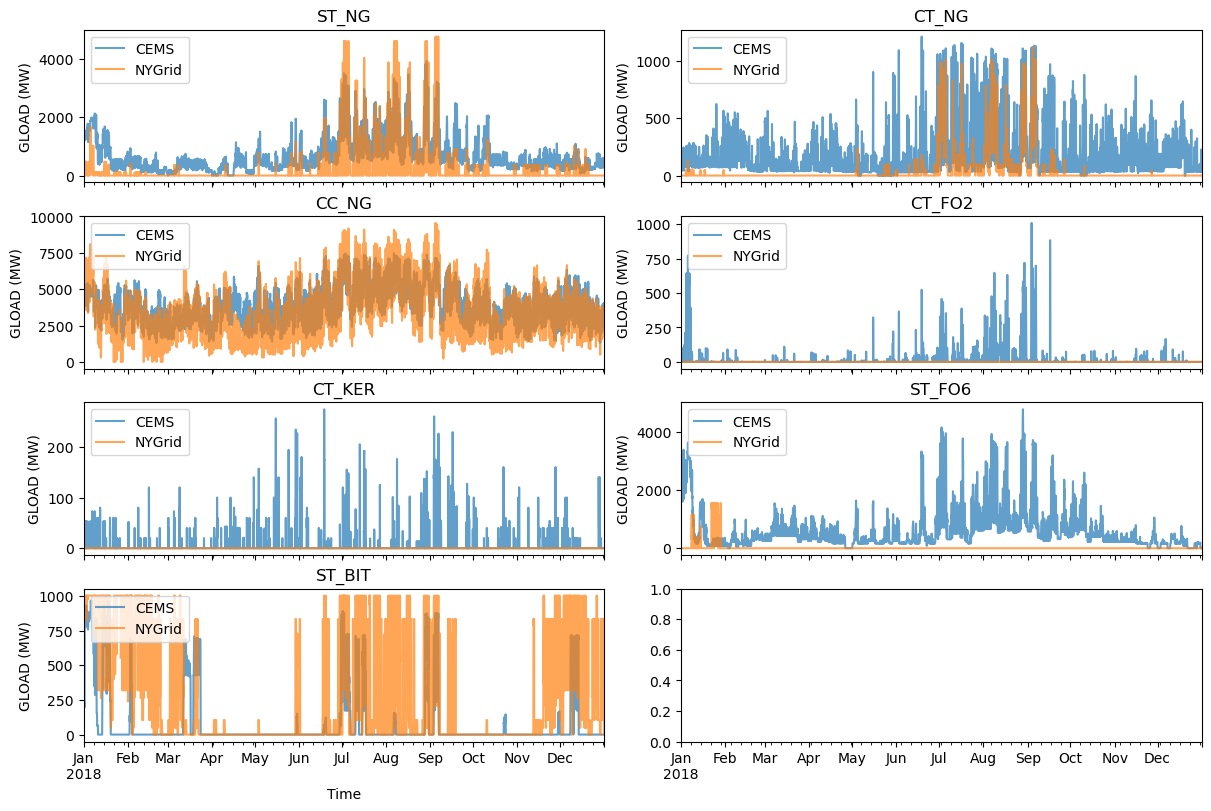

In [31]:
# By unit type and fuel type, whole year
num_gen_fuel = len(gen_fuel['GEN_FUEL'].unique())
fig, axs = plt.subplots(num_gen_fuel//2+1, 2, figsize=(12, 8),
                        sharex=True, layout='constrained')
for ii, gen_fuel_type in enumerate(gen_fuel['GEN_FUEL'].unique()):
    ax = axs.flatten()[ii]
    cems_gload_summary[gen_fuel_type].plot(ax=ax, alpha=0.7)
    nygrid_gload_summary[gen_fuel_type].plot(ax=ax, alpha=0.7)
    ax.set_title(gen_fuel_type)
    ax.set_ylabel('GLOAD (MW)')
    ax.legend(['CEMS', 'NYGrid'], loc='upper left')

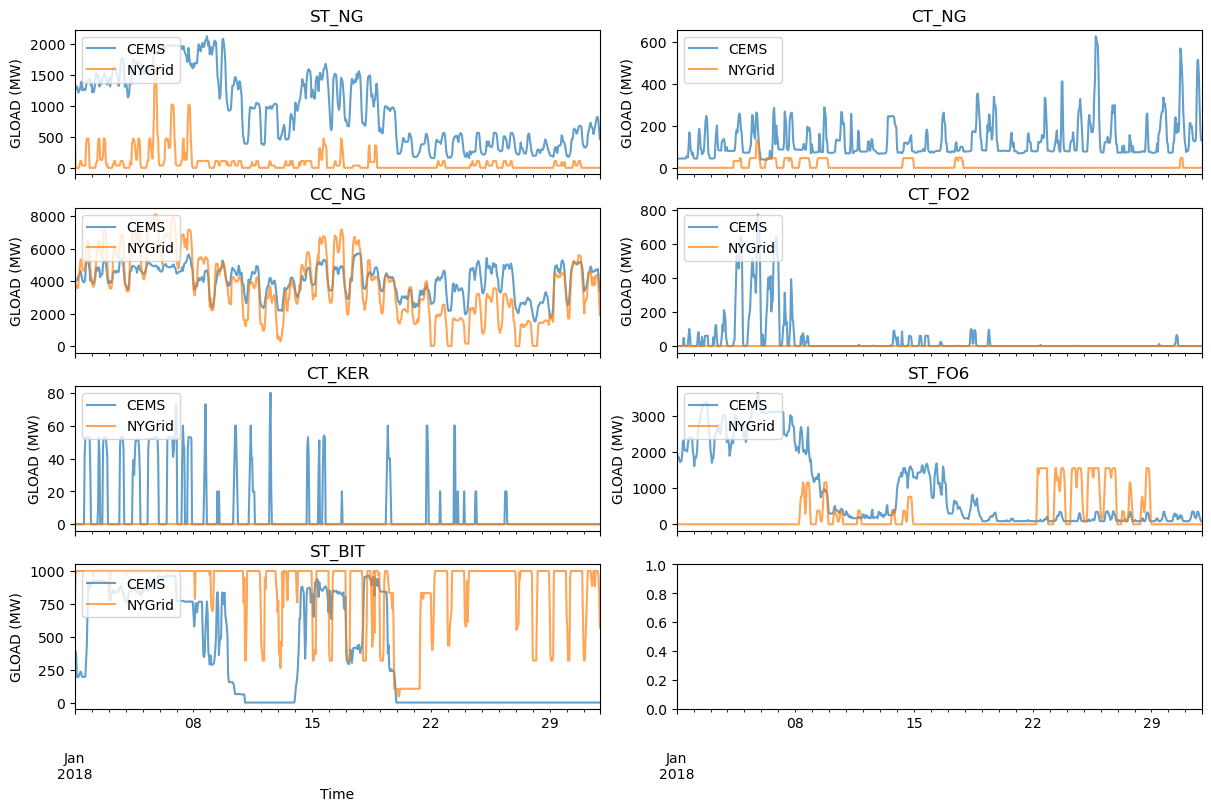

In [32]:
# By unit type and fuel type, January
num_gen_fuel = len(gen_fuel['GEN_FUEL'].unique())
fig, axs = plt.subplots(num_gen_fuel//2+1, 2, figsize=(12, 8),
                        sharex=True, layout='constrained')
for ii, gen_fuel_type in enumerate(gen_fuel['GEN_FUEL'].unique()):
    ax = axs.flatten()[ii]
    cems_gload_summary[gen_fuel_type].loc['2018-01'].plot(ax=ax, alpha=0.7)
    nygrid_gload_summary[gen_fuel_type].loc['2018-01'].plot(ax=ax, alpha=0.7)
    ax.set_title(gen_fuel_type)
    ax.set_ylabel('GLOAD (MW)')
    ax.legend(['CEMS', 'NYGrid'], loc='upper left')

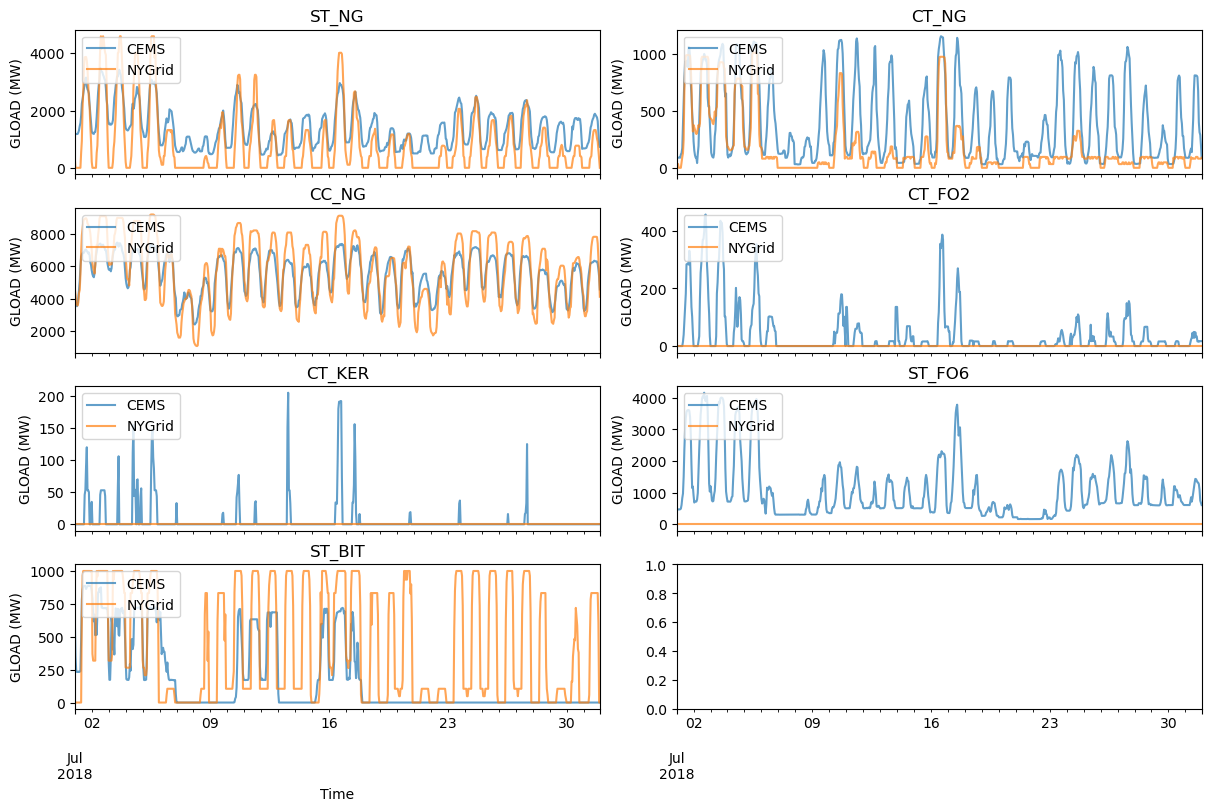

In [33]:
# By unit type and fuel type, July
num_gen_fuel = len(gen_fuel['GEN_FUEL'].unique())
fig, axs = plt.subplots(num_gen_fuel//2+1, 2, figsize=(12, 8),
                        sharex=True, layout='constrained')
for ii, gen_fuel_type in enumerate(gen_fuel['GEN_FUEL'].unique()):
    ax = axs.flatten()[ii]
    cems_gload_summary[gen_fuel_type].loc['2018-07'].plot(ax=ax, alpha=0.7)
    nygrid_gload_summary[gen_fuel_type].loc['2018-07'].plot(ax=ax, alpha=0.7)
    ax.set_title(gen_fuel_type)
    ax.set_ylabel('GLOAD (MW)')
    ax.legend(['CEMS', 'NYGrid'], loc='upper left')

In [34]:
gen_fuel = gen_combiner[['GEN_NAME','Fuel Type Primary']].copy()
gen_fuel_dict = gen_fuel.set_index('GEN_NAME')['Fuel Type Primary'].to_dict()

# GlOAD grouped by unit type and fuel type
cems_gload_summary = cems_gload_df.groupby(gen_fuel_dict, axis=1).sum()
nygrid_gload_summary = nygrid_glaod_df.groupby(gen_fuel_dict, axis=1).sum()
gen_fuel['Fuel Type Primary'].unique()

array(['NG', 'FO2', 'KER', 'FO6', 'BIT'], dtype=object)

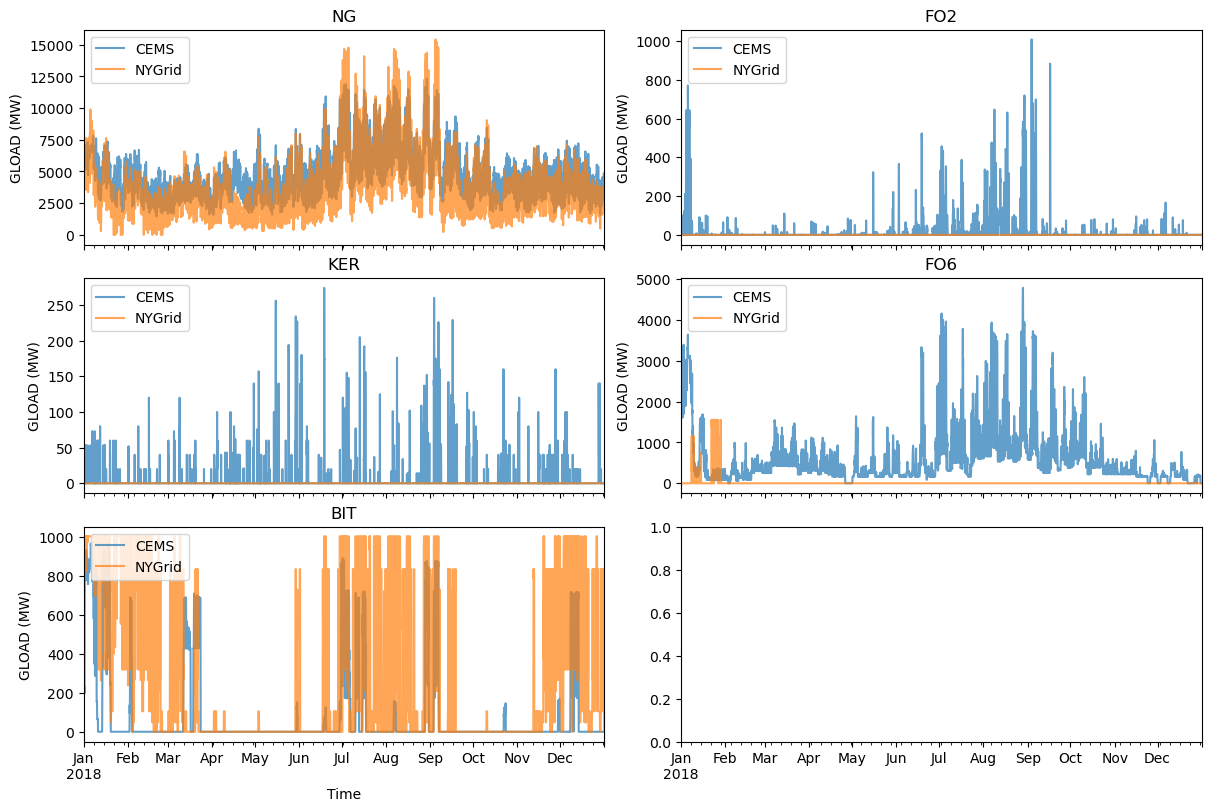

In [35]:
# By fuel type - whole year
num_gen_fuel = len(gen_fuel['Fuel Type Primary'].unique())
fig, axs = plt.subplots(num_gen_fuel//2+1, 2, figsize=(12, 8),
                        sharex=True, layout='constrained')
for ii, gen_fuel_type in enumerate(gen_fuel['Fuel Type Primary'].unique()):
    ax = axs.flatten()[ii]
    cems_gload_summary[gen_fuel_type].plot(ax=ax, alpha=0.7)
    nygrid_gload_summary[gen_fuel_type].plot(ax=ax, alpha=0.7)
    ax.set_title(gen_fuel_type)
    ax.set_ylabel('GLOAD (MW)')
    ax.legend(['CEMS', 'NYGrid'], loc='upper left')

# 5. Unit-level plots

In [15]:
output_dir = os.path.join(fig_dir, sim_name, 'thermal_pg')
os.makedirs(output_dir, exist_ok=True)

for ii in range(gen_combiner.shape[0]):
    gen_info = gen_combiner.iloc[ii]
    unit_df = pd.DataFrame({'cems_gload': cems_gload_df[gen_info['GEN_NAME']],
                            'nygrid_gload': nygrid_glaod_df[gen_info['GEN_NAME']],
                            'cems_heat_input': cems_heat_input_df[gen_info['GEN_NAME']],
                            'nygrid_heat_input': nygrid_heat_input_df[gen_info['GEN_NAME']]})
    
    fig_name_sfx = '_'.join([gen_info["ID"], gen_info["NYISO_Name"],
                                     gen_info["PTID"].astype(str),
                                     gen_info["Unit Type"], gen_info["Fuel Type Primary"],
                                     gen_info["Fuel Type Secondary"]])
    
    fig, ax = plt.subplots(2, 1, figsize=(8, 6), sharex=True)
    unit_df[['cems_gload', 'nygrid_gload']].plot(ax=ax[0], alpha=0.7)
    ax[0].set_title('GLOAD')
    ax[0].set_ylabel('GLOAD (MW)')
    ax[0].legend(['CEMS', 'NYGrid'], loc='upper left')

    unit_df[['cems_heat_input', 'nygrid_heat_input']].plot(ax=ax[1], alpha=0.7)
    ax[1].set_title('HEAT_INPUT')
    ax[1].set_ylabel('HEAT_INPUT (mmBtu)')
    ax[1].legend(['CEMS', 'NYGrid'], loc='upper left')

    fig.suptitle(fig_name_sfx)
    plt.tight_layout()
    fig.savefig(os.path.join(output_dir, f'{fig_name_sfx}.png'))
    plt.close('all')